In [1]:
# importing the librtaries
import numpy as np
import nltk
import re
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer 
import heapq
import json
import pandas as pd
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import time

C:\Users\victo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def import_data(corpus_jsonl, queries_jsonl):
    queries = []
    corpus = []
    with open(corpus_jsonl) as f:
        for line in f:
            data = json.loads(line)
            corpus += [data["text"]]
    with open(queries_jsonl) as f:
        for line in f:
            data = json.loads(line)
            queries += [data["text"]]
    return corpus, queries

In [3]:
corpus, queries = import_data('corpus.jsonl', 'queries.jsonl')

In [4]:
len(corpus)

3633

In [5]:
len(queries)

3237

# Sparse Representation

In [4]:
#class for preprocessing and creating word embedding
class Sparse_Representation:
    #constructor
    def __init__(self, corpus, queries):
        self.corpus = corpus
        self.queries = queries
        self.tfidfvectoriser=TfidfVectorizer(
            analyzer='word', token_pattern=r'\w{1,}', tokenizer=None, stop_words=None, ngram_range=(1, 1), 
            use_idf=True, smooth_idf=True, norm='l2', decode_error='replace', max_features=None, min_df=1, 
            max_df=1.0, strip_accents=None, binary=False, sublinear_tf=False)

    # Data Cleaning
    # remove extra spaces
    # convert sentences to lower case 
    # remove stopword
    def clean_sentence(self, sentence):
        sentence = sentence.lower().strip()
        sentence = re.sub(r'[^a-z0-9\s]', '', sentence)        
        sentence = remove_stopwords(sentence)
        return sentence

    # store cleaned sentences to cleaned_sentences
    def get_cleaned_sentences(self,data):
        cleaned_sentences = []
        for line in data:
            cleaned = self.clean_sentence(line)
            cleaned_sentences.append(cleaned)
        return cleaned_sentences

    #do all the cleaning
    def cleanall(self):
        cleaned_corpus = self.get_cleaned_sentences(self.corpus)
        cleaned_queries = self.get_cleaned_sentences(self.queries)        
        return cleaned_corpus, cleaned_queries

    # TF-IDF Vectorizer
    def TFIDF(self,cleaned_corpus):
        self.tfidfvectoriser.fit(cleaned_corpus)
        tfidf_vectors=self.tfidfvectoriser.transform(cleaned_corpus)
        return (tfidf_vectors)

    #tfidf for question
    def TFIDF_Q(self,cleaned_queries):
        tfidf_vectors=self.tfidfvectoriser.transform(cleaned_queries)
        return (tfidf_vectors)

    # main call function
    def RetrieveAnswer(self): 
        cleaned_corpus, cleaned_queries = self.cleanall()
        tfidf = self.TFIDF(cleaned_corpus)
        tfidf_q = self.TFIDF_Q(cleaned_queries)
        scores = np.dot(tfidf,tfidf_q.T)
        return scores.toarray()

In [5]:
#sparse rappresentation
sparse_model = Sparse_Representation(corpus, queries)
sparse_scores = sparse_model.RetrieveAnswer()
pd.DataFrame(sparse_scores.T) #row = queries, column = documents

,0,1,2,3,4,5,6,7,8,9,...,3623,3624,3625,3626,3627,3628,3629,3630,3631,3632
0,0.187755,0.305666,0.000000,0.000000,0.0,0.015051,0.014030,0.000000,0.0,0.0,...,0.077636,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.011713,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.006543,0.0,0.0,...,0.000000,0.005238,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.010520,0.000000,0.0,0.0,0.027857,0.0,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,0.020986,0.021880,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3232,0.015058,0.000000,0.000000,0.000000,0.0,0.000000,0.030395,0.032723,0.0,0.0,...,0.000000,0.013098,0.000000,0.000000,0.0,0.0,0.014817,0.0,0.000000,0.012023
3233,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
3234,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.042291,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
3235,0.000000,0.000000,0.144423,0.016505,0.0,0.014925,0.039583,0.014977,0.0,0.0,...,0.000000,0.000000,0.034072,0.021995,0.0,0.0,0.021674,0.0,0.000000,0.000000


# Dense Representation

In [6]:
#class for preprocessing and creating word embedding
class Dense_Representation:
    #constructor
    def __init__(self, corpus, queries):
        self.corpus = corpus
        self.queries = queries
        # Load the all-MiniLM-L6-v2 model
        self.model = SentenceTransformer('all-MiniLM-L6-v2')

    # Data Cleaning
    # remove extra spaces
    # convert sentences to lower case 
    # remove stopword
    def clean_sentence(self, sentence):
        sentence = sentence.lower().strip()
        sentence = re.sub(r'[^a-z0-9\s]', '', sentence)        
        sentence = remove_stopwords(sentence)
        return sentence

    # store cleaned sentences to cleaned_sentences
    def get_cleaned_sentences(self,data):
        cleaned_sentences = []
        for line in data:
            cleaned = self.clean_sentence(line)
            cleaned_sentences.append(cleaned)
        return cleaned_sentences

    #do all the cleaning
    def cleanall(self):
        cleaned_corpus = self.get_cleaned_sentences(self.corpus)
        cleaned_queries = self.get_cleaned_sentences(self.queries)        
        return [cleaned_corpus, cleaned_queries]

    # Generate dense representations for the documents
    def embedder_documents(self,cleaned_corpus):        
        embeddings = self.model.encode(cleaned_corpus)
        return embeddings

    # Generate dense representations for the queries
    def embedder_queries(self,cleaned_queries):
        embeddings = self.model.encode(cleaned_queries)
        return embeddings
   
    def RetrieveAnswer(self): 
        cleaned_corpus, cleaned_queries = self.cleanall()
        print('start corpus')
        corpus_embeddings = self.embedder_documents(cleaned_corpus)
        print('start query')
        query_embeddings = self.embedder_queries(cleaned_queries)
        print('start dot prod')
        scores = np.dot(corpus_embeddings,query_embeddings.T)
        return scores

In [7]:
dense_model = Dense_Representation(corpus, queries)
dense_scores = dense_model.RetrieveAnswer()
pd.DataFrame(dense_scores.T)

start corpus
start query
start dot prod


,0,1,2,3,4,5,6,7,8,9,...,3623,3624,3625,3626,3627,3628,3629,3630,3631,3632
0,0.298085,0.357741,0.173295,-0.030394,0.014089,0.105433,0.088003,0.071574,0.018314,0.057710,...,0.325889,0.079962,0.034433,0.095262,0.043838,0.120084,0.209750,-0.012842,0.057810,0.150818
1,0.015641,-0.018157,0.141233,0.084428,0.034168,-0.006077,0.071059,0.083993,0.109229,0.077600,...,0.072040,0.199295,0.011777,0.190025,0.293993,0.152965,0.155450,0.079268,0.043085,0.054627
2,0.166974,0.070494,0.173557,0.097512,0.140254,0.030020,0.098412,0.099059,0.206172,0.053680,...,0.248363,0.174810,0.148431,0.076994,0.214683,0.245757,0.105126,0.171179,0.264398,0.203499
3,0.085646,0.043782,0.164696,0.090844,0.115396,-0.002187,0.114407,0.111804,0.209825,0.133208,...,0.121491,0.174173,0.025209,0.176020,0.296748,0.425989,0.210272,0.154363,0.209899,0.125606
4,0.095827,0.055058,0.199045,0.120322,0.121814,0.003207,0.127507,0.127377,0.222800,0.147304,...,0.106256,0.175801,0.022355,0.187267,0.284075,0.427219,0.204171,0.139057,0.229249,0.122001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3232,0.064157,0.099452,0.223826,-0.014170,0.003560,0.013020,0.017448,0.067791,0.172141,0.196244,...,-0.017157,0.250344,0.051654,0.095214,0.172078,0.223300,0.083884,0.082046,0.084565,0.170767
3233,0.121772,0.147618,0.301386,0.051548,0.028571,0.098959,0.162023,0.247617,0.376419,0.304458,...,0.173963,0.244643,0.060751,0.183167,0.148809,0.390280,0.294709,0.223605,0.159694,0.217253
3234,0.050589,0.003400,0.110520,-0.026404,0.117410,0.002353,0.053139,0.070707,0.138257,0.085332,...,-0.076929,0.161893,0.129040,0.064490,-0.001599,0.030253,-0.104524,0.069931,0.049847,0.097142
3235,0.136953,0.077294,0.277106,0.095050,-0.026087,0.201477,0.244829,0.101308,0.079646,0.139887,...,0.051144,0.060599,0.150245,0.175785,0.051605,0.121398,0.087455,0.104775,-0.021664,0.186894


In [14]:
sparse_scores = pd.DataFrame(sparse_scores)
dense_scores = pd.DataFrame(dense_scores)

# Sum of Sparse and Dense Matrices to find top-k documents

In [8]:
#for each query we have its documents sorted by scores
def sort_score(df):
    size = df.shape
    sorted_score = np.empty([size[0], size[1]], dtype=int)
    
    for i in range(len(df)):
        sorted_score[i] = np.argsort(df.iloc[i]).values[::-1]
        
    return sorted_score

In [25]:
sparse_scores.shape

(3633, 3237)

In [72]:
#not efficient to compare wirh merge score, cause merge scores it's not implemented in an efficient way
def sum_scores2(sparse_scores, dense_scores, top_k):
    scores = np.empty([sparse_scores.shape[0], sparse_scores.shape[1]], dtype=int)
    for i in range(sparse_scores.shape[0]):
        for j in range(sparse_scores.shape[1]):
            scores[i][j] = sparse_scores.iloc[i,j] + dense_scores.iloc[i,j]
    return sort_score(pd.DataFrame(scores.T))[:,:top_k] #for each query get top_k documents

In [67]:
#efficent sum scores
def sum_scores(sparse_scores, dense_scores, top_k):
    scores = ((sparse_scores + dense_scores).T) #row as query, documents as column        
    return sort_score(scores)[:,:top_k] #for each query get top_k documents


In [73]:
start_time = time.time()
S = sum_scores2(sparse_scores, dense_scores, 10)
print("--- %s seconds ---" % (time.time() - start_time))

--- 357.95606231689453 seconds ---


In [22]:
S

array([[2078, 1377, 1380, ..., 1104, 2518, 2790],
       [1498, 1396, 1401, ..., 1393, 2212, 1507],
       [1507, 1401, 3323, ..., 1411, 1405, 2119],
       ...,
       [3423,  233,  245, ..., 3080,  244,  238],
       [3518,  509, 3515, ..., 3517, 3402, 3522],
       [2251, 2253, 2116, ...,  239, 2256, 3621]])

# Merge top-k’ to find top-k documents

In [20]:
def merge_k_scores(sparse_scores, dense_scores, top_k1, top_k):
    sparse = sort_score(sparse_scores.T)[:,:top_k1] #row = query - top k1 documents for query
    
    dense = sort_score(dense_scores.T)[:,:top_k1] #row = query - top k1 documents for query   
    
    conc =  np.concatenate((sparse.T, dense.T)).T #row = query - 2*top k1 documents for query
    sorted_score = np.empty([len(sparse), top_k], dtype=int)
    for q in range(len(sparse)):
        d = dict() #aux structure
        row = conc[q]
        for i in row: #inizializate
            d[i] = 0
        for i in sparse[q]:
            d[i] += sparse_scores.iloc[i, q]
        for i in dense[q]:    
            d[i] += dense_scores.iloc[i, q]
      
        sorted_keys = sorted(d, key=lambda x: d[x], reverse=True)[:top_k]
        sorted_score[q] = sorted_keys
    return sorted_score

In [21]:
start_time = time.time()
S_1 = merge_k_scores(sparse_scores, dense_scores, 100, 10)
print("--- %s seconds ---" % (time.time() - start_time))

--- 9.534319400787354 seconds ---


# Recall

In [13]:
def recall_array(sparse_scores, dense_scores, top_k1, top_k):
    scores1 = sum_scores(sparse_scores, dense_scores, top_k) #row= query column = douments
    recall_arr = np.zeros([len(scores1), top_k1], dtype=float)
    
    for j in range(top_k, top_k1):
        scores2 = merge_k_scores(sparse_scores, dense_scores, j+1, top_k) #row= query column = douments
        
        for i in range(len(scores1)):
            S = np.intersect1d(scores1[i], scores2[i])
            
            recall_arr[i][j] = S.size/top_k       
            #print('top_k1 = '+ str(j + 1) + ', recall = ' + str(S.size/top_k))
    return recall_arr
        

In [16]:
drop_indices = np.random.choice(sparse_scores.T.index, 3000, replace=False)
df_subset_sparse = sparse_scores.T.drop(drop_indices)
df_subset_dense = dense_scores.T.drop(drop_indices)
recall1 = recall_array(df_subset_sparse.T, df_subset_dense.T, 500, 1) #row = query, column = top_k1

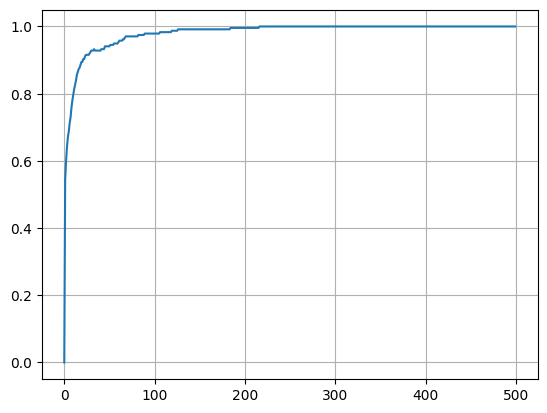

In [17]:
# calculate the mean of all columns
mean_recall1 = np.mean(recall1, axis=0)
# print the mean of all rows
plt.plot(mean_recall1)
plt.grid()

In [20]:
drop_indices = np.random.choice(sparse_scores.T.index, 3000, replace=False)
df_subset_sparse = sparse_scores.T.drop(drop_indices)
df_subset_dense = dense_scores.T.drop(drop_indices)
recall2 = recall_array(df_subset_sparse.T, df_subset_dense.T, 500, 5) #row = query, column = top_k1

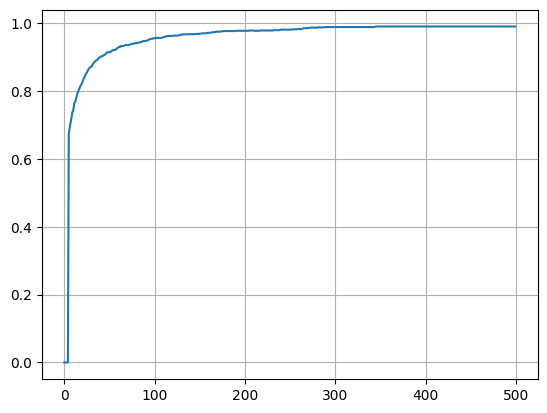

In [21]:
# calculate the mean of all columns
mean_recall2 = np.mean(recall2, axis=0)
# print the mean of all rows
plt.plot(mean_recall2)
plt.grid()

In [31]:
drop_indices = np.random.choice(sparse_scores.T.index, 3000, replace=False)
df_subset_sparse = sparse_scores.T.drop(drop_indices)
df_subset_dense = dense_scores.T.drop(drop_indices)
recall3 = recall_array(df_subset_sparse.T, df_subset_dense.T, 1000, 50) #row = query, column = top_k1

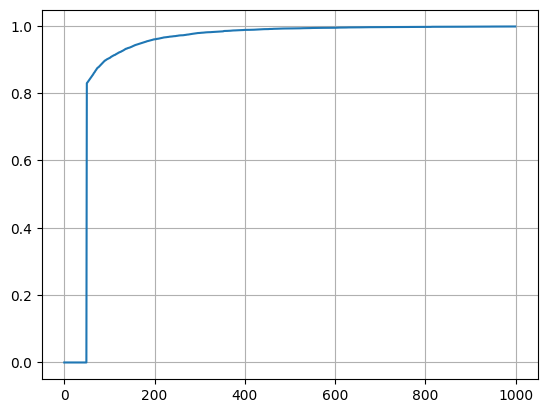

In [32]:
# calculate the mean of all columns
mean_recall3 = np.mean(recall3, axis=0)
# print the mean of all rows
plt.plot(mean_recall3)
plt.grid()

In [28]:
drop_indices = np.random.choice(sparse_scores.T.index, 3000, replace=False)
df_subset_sparse = sparse_scores.T.drop(drop_indices)
df_subset_dense = dense_scores.T.drop(drop_indices)
recall4 = recall_array(df_subset_sparse.T, df_subset_dense.T, 1000, 100) #row = query, column = top_k1

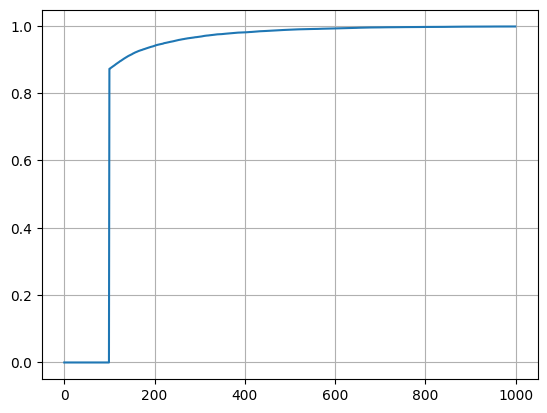

In [29]:
# calculate the mean of all columns
mean_recall4 = np.mean(recall4, axis=0)
# print the mean of all rows
plt.plot(mean_recall4)
plt.grid()